In [140]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib.patches import FancyBboxPatch, BoxStyle

def split_into_chromosomes(genotype):
    chr_list = genotype.split(';')
    chr_list = [chr.strip() for chr in chr_list]
    if len(chr_list) < 3:
        chr_list = ['+/+'] + chr_list
    chr_list = ['+/+' if chromosome == '' else chromosome for chromosome in chr_list]
    chr_list = [chromosome.split('/') for chromosome in chr_list]
    chr_list = [chromosome*2 if len(chromosome)==1 else chromosome for chromosome in chr_list]
    return chr_list

def fix_genotype_notation(genotype):
    return join_chromosomes(split_into_chromosomes(genotype))

def join_chromosomes(chromosome_list):
    return ' ; '.join(['/'.join(chromosome) for chromosome in chromosome_list])

def get_progeny(fly1,fly2,balancers_table=None):
    possible_chromosomes = [set([x for x in itertools.product(fly1[ichr],fly2[ichr])]) for ichr in range(3)]
    possible_chromosomes = [[alleles for alleles in chromosome_list if not ((alleles[0]==alleles[1]) and (alleles[0] in balancers_table.label.tolist()))] for chromosome_list in possible_chromosomes]
    possible_progeny = [z for z in itertools.product(*possible_chromosomes)]
    progeny_genotypes = [join_chromosomes(chromosome_list) for chromosome_list in possible_progeny]
    return progeny_genotypes

In [125]:
goal_genotype = '+/+ ; UAS<stop>Kir2.1/UAS<stop>Kir2.1 ; VT40556-Gal4, fru-FLP/VT40556-Gal4, fru-FLP'
goal_genotype = fix_genotype_notation(goal_genotype)
goal_genotype

'+/+ ; UAS<stop>Kir2.1/UAS<stop>Kir2.1 ; VT40556-Gal4, fru-FLP/VT40556-Gal4, fru-FLP'

In [126]:
fly_stock_table = pd.read_excel('simple_crosses_table.xlsx')
balancers_table = pd.read_excel('balancers_table.xlsx')
fly_stock_table['split_genotype'] = [split_into_chromosomes(genotype) for genotype in fly_stock_table.genotype]
fly_stock_table

,ID,description,genotype,split_genotype
0,B#67686,UAS > stop > Kir2.1 on chr2,w[*]; UAS<stop>Kir2.1/CyO ;,"[[w[*], w[*]], [UAS<stop>Kir2.1, CyO], [+, +]]"
1,S#272,"Chrimson pIP10 from Philipsborn 2011, VT40556-...",";UAS<stop>Chrimson,mVenus/CyO; VT40556-Gal4, f...","[[+, +], [UAS<stop>Chrimson,mVenus, CyO], [VT4..."
2,balancers,NaN,; s/CyO ; Tm2/Tm6b,"[[+, +], [s, CyO], [Tm2, Tm6b]]"


In [138]:
[set([x for x in itertools.product(fly1[ichr],fly2[ichr])]) for ichr in range(3)]

for ichr in range(3):
    set([x for x in itertools.product(fly1[ichr],fly2[ichr])])

[{(';', ';')}, {(' ', ' ')}, {('s', 's')}]

In [136]:
print(fly_stock_table.genotype[2])
get_progeny(fly1=fly_stock_table.genotype[2],fly2=fly_stock_table.genotype[2],balancers_table=balancers_table)

; s/CyO ; Tm2/Tm6b
[{(';', ';')}, {(' ', ' ')}, {('s', 's')}]


[]

In [144]:
for fly1, fly2 in itertools.product(fly_stock_table.genotype,fly_stock_table.genotype):
    progeny_genotypes = get_progeny(fly1=split_into_chromosomes(fly1),fly2=split_into_chromosomes(fly2),balancers_table=balancers_table)
    if goal_genotype not in progeny_genotypes:
        second_step_stock = [fly1, fly2] + progeny_genotypes
        for fly3, fly4 in itertools.product(second_step_stock,second_step_stock):
            second_progeny_genotypes = get_progeny(fly1=split_into_chromosomes(fly3),fly2=split_into_chromosomes(fly4),balancers_table=balancers_table)
            if goal_genotype in second_progeny_genotypes:
                print('viable cross plan')
                print(fly1,' x ', fly2)
                print(fly3,' x ', fly4)
    else:
        print('viable cross plan')
        print(fly1,' x ', fly2)


viable cross plan
w[*]; UAS<stop>Kir2.1/CyO ;  x  ;UAS<stop>Chrimson,mVenus/CyO; VT40556-Gal4, fru-FLP/Tm6b
w[*]/+ ; UAS<stop>Kir2.1/UAS<stop>Chrimson,mVenus ; +/VT40556-Gal4, fru-FLP  x  w[*]/+ ; UAS<stop>Kir2.1/UAS<stop>Chrimson,mVenus ; +/VT40556-Gal4, fru-FLP
viable cross plan
w[*]; UAS<stop>Kir2.1/CyO ;  x  ;UAS<stop>Chrimson,mVenus/CyO; VT40556-Gal4, fru-FLP/Tm6b
w[*]/+ ; UAS<stop>Kir2.1/UAS<stop>Chrimson,mVenus ; +/VT40556-Gal4, fru-FLP  x  w[*]/+ ; UAS<stop>Kir2.1/CyO ; +/VT40556-Gal4, fru-FLP
viable cross plan
w[*]; UAS<stop>Kir2.1/CyO ;  x  ;UAS<stop>Chrimson,mVenus/CyO; VT40556-Gal4, fru-FLP/Tm6b
w[*]/+ ; UAS<stop>Kir2.1/CyO ; +/VT40556-Gal4, fru-FLP  x  w[*]/+ ; UAS<stop>Kir2.1/UAS<stop>Chrimson,mVenus ; +/VT40556-Gal4, fru-FLP
viable cross plan
w[*]; UAS<stop>Kir2.1/CyO ;  x  ;UAS<stop>Chrimson,mVenus/CyO; VT40556-Gal4, fru-FLP/Tm6b
w[*]/+ ; UAS<stop>Kir2.1/CyO ; +/VT40556-Gal4, fru-FLP  x  w[*]/+ ; UAS<stop>Kir2.1/CyO ; +/VT40556-Gal4, fru-FLP
viable cross plan
;UAS<stop>

# Working on the visualization

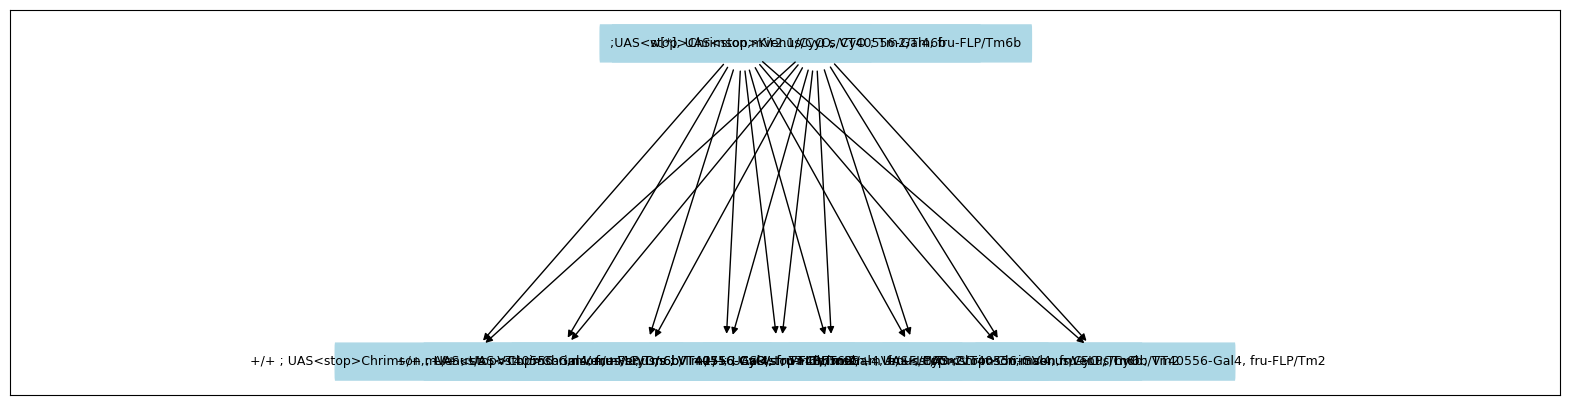

In [128]:
fig, ax = plt.subplots(figsize=[20,5])

# create graph
G = nx.DiGraph()
for gen,xscale_fly in zip(fly_stock_table.genotype,[3,1.8,4]):
    G.add_node(gen, xscale = xscale_fly)
for gen,xscale_fly in zip(progeny_genotypes,[3]*len(progeny_genotypes)):
    G.add_node(gen, xscale = xscale_fly)
for parent, progeny in itertools.product(fly_stock_table.genotype[[0,1]],progeny_genotypes):
    G.add_edge(parent,progeny)

# get positions for graph 
pos = graphviz_layout(G, prog="dot")
# plot graph
nx.draw_networkx_edges(G, pos=pos, ax=ax, min_source_margin=20, min_target_margin=20)

# scale of ax to draw rectangles and labels over
xscale = (ax.get_xlim()[1] - ax.get_xlim()[0])
yscale = (ax.get_ylim()[1] - ax.get_ylim()[0])

# plot rectangles and labels
for n in G.nodes:
    label_size_x = xscale/G.nodes[n]['xscale']
    label_size_y = yscale/20
    fancybox = FancyBboxPatch(np.asarray(pos[n]) - np.asarray((label_size_x/2,label_size_y/2)), label_size_x, label_size_y, color='lightblue', zorder=-5, boxstyle=BoxStyle("Round", pad=2))
    ax.add_patch(fancybox)
    ax.text(*pos[n],n,ha='center',va='center',fontsize=9)
plt.xlim([ax.get_xlim()[0]-0.5*xscale,ax.get_xlim()[1]+0.5*xscale])
plt.show()